# **Classifying Images with Deep Convolutional Neural Networks (Part 2/2)**


**Outline**

- **Smile classification from face images using a CNN**
    - Loading the CelebA dataset
    - Image transformation and data augmentation
    - Training a CNN smile classifier

- the goal of this section is to build and train a `CNN` model for predicting the smile attribute from these face images.

- Here, for simplicity, we will only be using a small portion of the training data (`16,000` training examples) to speed up the training process.

- However, to improve the generalization performance and reduce overfitting on such a small dataset, we will use a technique called `data augmentation`.

In [1]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## **Smile classification from face images using CNN**


### **Loading the CelebA dataset**

- First, let’s load the data similarly to how we did in the previous section for the MNIST dataset. `CelebA` data comes in three partitions: 
  - a training dataset, 
  - a validation dataset, and 
  - a test dataset.
- Next, we will count the number of examples in each partition:

In [2]:
import torchvision 

image_path = '../data/'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False)

celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                  split='test', 
                                                  target_type='attr', 
                                                  download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


#### **Data Augmentation in CNNs**

**Data augmentation** artificially expands a training dataset by applying realistic transformations to input images. This improves generalization, reduces overfitting, and makes CNNs more robust to variations in real-world data.

**Common Augmentation Techniques**

* **Geometric transforms**

  * Random flips (horizontal/vertical)
  * Random rotations
  * Random crops / resized crops
  * Random translations
  * Random zoom / scale changes

* **Color/appearance transforms**

  * Brightness, contrast, saturation adjustments
  * Color jittering
  * Grayscale conversion

* **Noise and distortion**

  * Gaussian noise
  * Blur/sharpen
  * Cutout / random erasing

**Why Augmentation Helps**

* Prevents CNNs from memorizing training examples

* Encourages learning of invariant features (shape, texture, edges)

* Acts as a strong form of regularization

* Effectively increases dataset size without collecting new data

**Typical PyTorch Implementation**

Augmentations are applied to input images **only during training**, usually via `torchvision.transforms`, for example:

* `RandomHorizontalFlip()`
* `RandomRotation()`
* `RandomResizedCrop()`
* `ColorJitter()`

These operations create new, varied versions of images on the fly, allowing the CNN to see fresh examples at each epoch.


### **Image transformation and data augmentation**

In the following code block, we will first get five examples from the `celeba_train_dataset` dataset and apply five different types of transformation:

1. `cropping an image to a bounding-box`
2. `flipping an image horizontally`
3. `adjusting the contrast`
4. `adjusting the brightness`
5. `cropping from image center and resizing the resulting image back to its original size`


In the following code, we will visualize the results of these transformations, showing each one in a separate column for comparison:

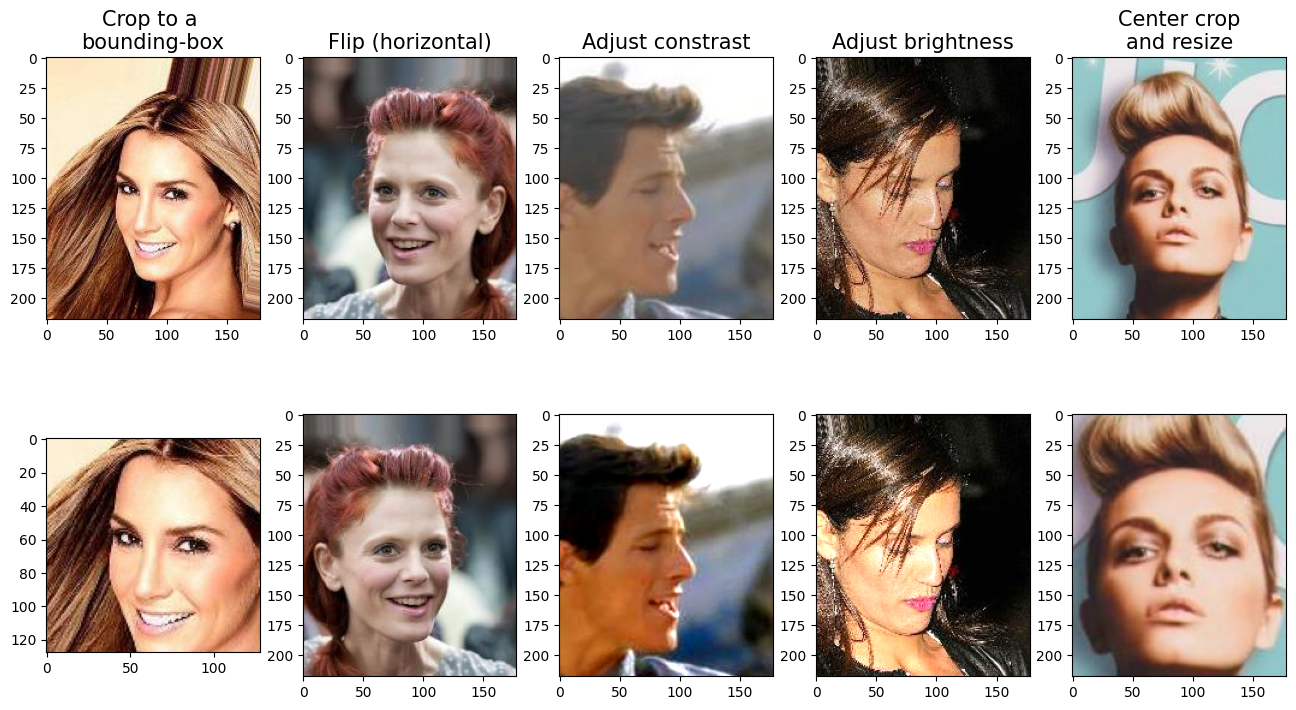

In [3]:
from torchvision import transforms 

## take 5 examples

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
 
# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

- the original images are shown in the first row and their transformed versions in the second row.

- Note that for the first transformation (leftmost column), the bounding box is specified by four numbers: the coordinate of the upper-left corner of the bounding box `(here x=20, y=50)`, and the width and height of the box `(width=128, height=128)`. Also note that the origin (the coordinates at the location denoted as `(0, 0)`) for images loaded by PyTorch (as well as other packages such as imageio) is the upper-left corner of the image.

- The transformations in the previous code block are deterministic. However, all such transformations can also be randomized, which is recommended for data augmentation during model training. For example, a random bounding box (where the coordinates of the upper-left corner are selected randomly) can be cropped from an image, an image can be randomly flipped along either the horizontal or vertical axes with a probability of `0.5`, or the contrast of an image can be changed randomly, where the `contrast_factor` is selected at random, but with uniform distribution, from a range of values. In addition, we can create a pipeline of these transformations.


- For example, we can first randomly crop an image, then flip it randomly, and finally, resize it to the desired size. The code is as follows (since we have random elements, we set the random seed for reproducibility):

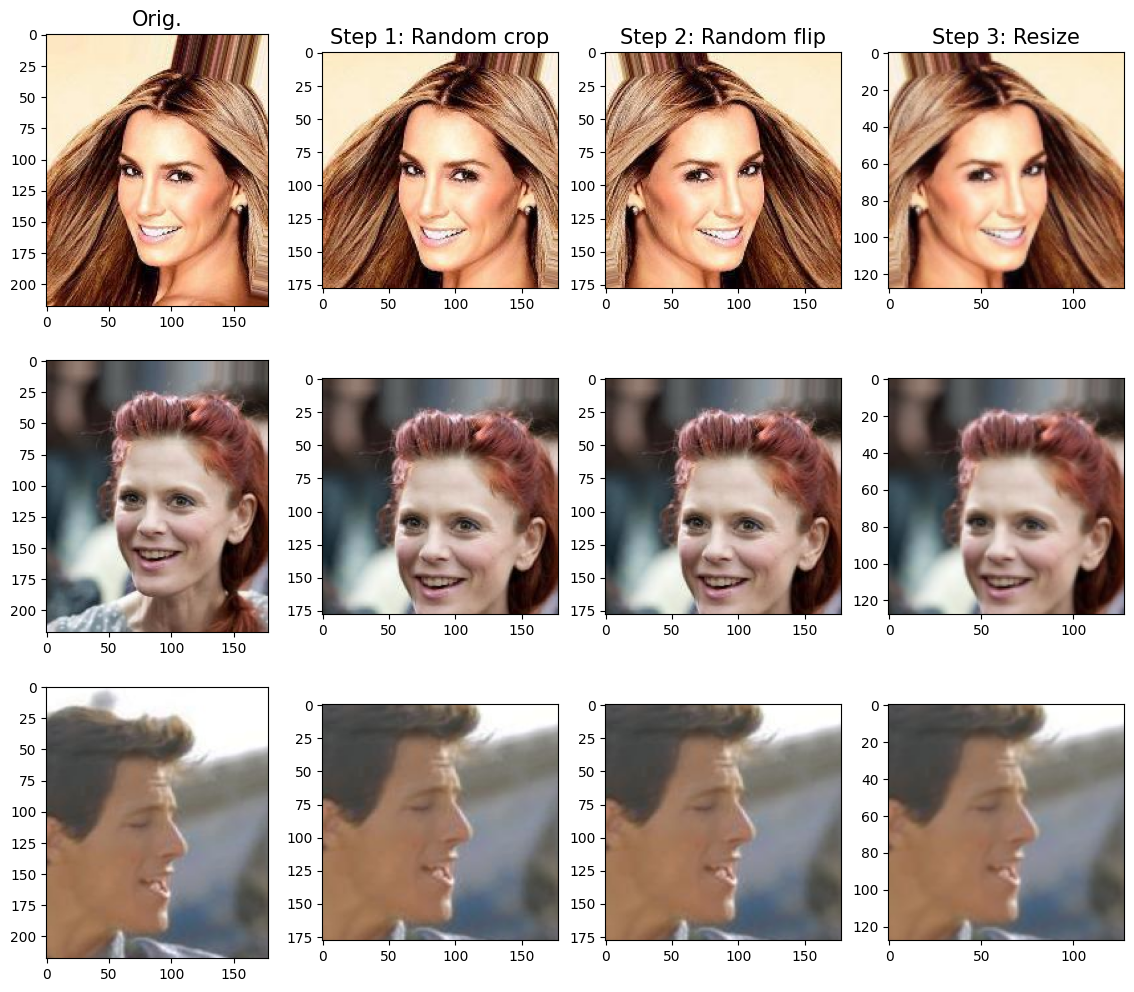

In [9]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    
    if i == 2:
        break
        
# plt.savefig('figures/14_15.png', dpi=300)
plt.show()

- Note that each time we iterate through these three examples, we get slightly different images due to random transformations.

- For convenience, we can define transform functions to use this pipeline for data augmentation during dataset loading.

- In the following code, we will define the function `get_smile`, which will extract the smile label from the `'attributes'` list:

- We will define the `transform_train` function that will produce the transformed image (where we will first randomly crop the image, then flip it randomly, and finally, resize it to the desired size `64×64`):

In [10]:
get_smile = lambda attr: attr[31]
 
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

- We will only apply data augmentation to the training examples, however, and not to the validation or test images. The code for the validation or test set is as follows (where we will first simply crop the image and then resize it to the desired size `64×64`):

In [11]:
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

- Now, to see data augmentation in action, let’s apply the `transform_train` function to our training dataset and iterate over the dataset five times:

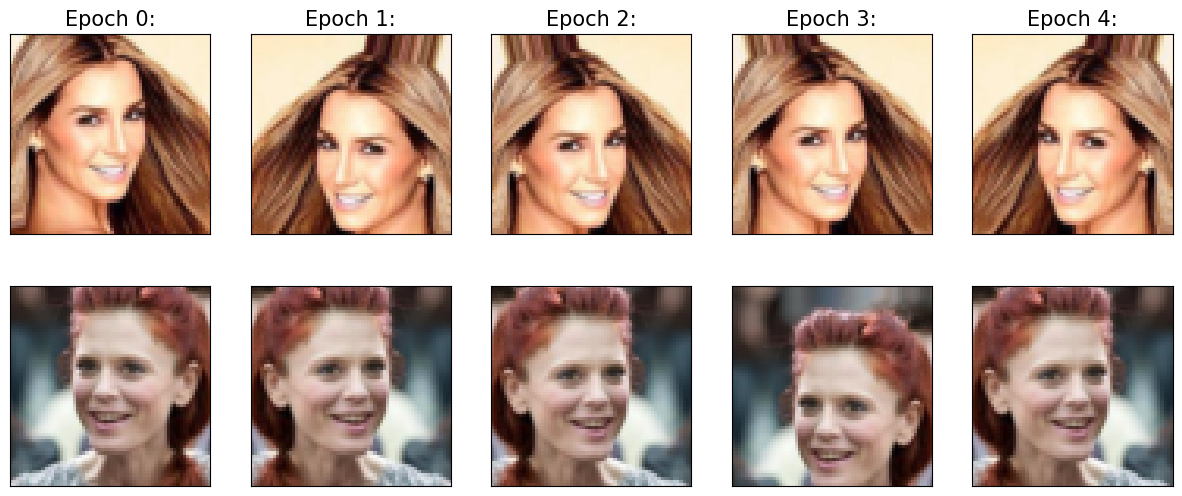

In [12]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
      
    
#plt.savefig('figures/14_16.png', dpi=300)
plt.show()

- Next, we will apply the transform function to our validation and test datasets:

In [13]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 
 
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


- instead of using all the available training and validation data, we will take a subset of `16,000` training examples and `1,000` examples for validation, as our goal here is to intentionally train our model with a small dataset.

- Now, we can create data loaders for three datasets:

In [14]:
batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, 
                      batch_size, 
                      shuffle=True)

valid_dl = DataLoader(celeba_valid_dataset, 
                      batch_size, 
                      shuffle=False)

test_dl = DataLoader(celeba_test_dataset, 
                     batch_size, 
                     shuffle=False)

## **Training a CNN Smile classifier**

- Design of our `CNN` is as follows:
  - the `CNN` model receives input images of size `3 x 64 x 64` (the images have three color channels).
  - the input data goes through four convolutional layers to make `32, 64, 128, and 256` feature maps using filters with a kernel size `3 x 3` and padding of `1` for same padding.
  - The first three convolution layers are followed by max-pooling, $P_{2 \times 2}$.
  - Two dropout layers are also included for regularization.

In [15]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', 
                 nn.Conv2d(in_channels=3, 
                            out_channels=32, 
                            kernel_size=3, 
                            padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', 
                 nn.Conv2d(in_channels=32, 
                            out_channels=64, 
                            kernel_size=3, 
                            padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', 
                 nn.Conv2d(in_channels=64, 
                            out_channels=128, 
                            kernel_size=3, 
                            padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', 
                 nn.Conv2d(in_channels=128, 
                            out_channels=256, 
                            kernel_size=3, 
                            padding=1))
model.add_module('relu4', nn.ReLU())  

- Let’s see the shape of the output feature maps after applying these layers using a toy batch input (four images arbitrarily):

In [16]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

**Global Average Pooling**

Suppose a CNN produces **256 feature maps**, each of spatial size **8×8**.

* Flattening them gives:

  $`8 \times 8 \times 256 = 16,384`$ units → fed into a fully connected layer.

**Global Average Pooling (GAP)** is a more compact alternative:

* GAP computes **one average value per feature map**, reducing each 8×8 map to a single scalar.

* Output size becomes:
  $`256`$ (instead of 16,384).

* This drastically reduces parameters and helps prevent overfitting.

**Key idea:**

GAP is simply **average pooling with a kernel size equal to the entire feature map**.

**Example**

Given feature maps of shape:
$`\text{batchsize} \times 8 \times 64 \times 64`$
(with 8 channels)

GAP computes the spatial mean of each $`64 \times 64`$ map → producing:
$`\text{batchsize} \times 8 \times 1 \times 1`$

After squeezing (removing singleton dimensions):
$`\text{batchsize} \times 8`$

This output is then passed to a final fully connected (linear) layer for classification or regression.


![Input feature maps](./figures/input-feature-maps.png)


- Therefore, given that, in our case, the shape of the feature maps prior to this layer is `[batchsize×256×8×8]`, we expect to get `256` units as output, that is, the shape of the output will be `[batchsize×256]`. Let’s add this layer and recompute the output shape to verify that this is true:

In [17]:
model.add_module('pool4', 
                 nn.AvgPool2d(kernel_size=8)) 

model.add_module('flatten', 
                 nn.Flatten()) 

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

- Finally, we can add a fully connected layer to get a single output unit. In this case, we can specify the activation function to be `'sigmoid'`:

In [18]:
model.add_module('fc', 
                 nn.Linear(256, 1)) 
model.add_module('sigmoid', 
                 nn.Sigmoid()) 

In [19]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [20]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [22]:
device = torch.device("mps")
# device = torch.device("cpu")
model = model.to(device) 

In [23]:
device

device(type='mps')

- The next step is to create a loss function and optimizer (`Adam optimizer` again). For a binary classification with a single probabilistic output, we use `BCELoss` for the loss function:

In [24]:
learning_rate = 1e-3

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- Now we can train the model by defining the following function.
- we will train this CNN model for `30 epochs` and use the validation dataset that we created for monitoring the learning progress:

In [25]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5104 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5175 val_accuracy: 0.5140
Epoch 3 accuracy: 0.5288 val_accuracy: 0.5420
Epoch 4 accuracy: 0.5569 val_accuracy: 0.5760
Epoch 5 accuracy: 0.5882 val_accuracy: 0.6080
Epoch 6 accuracy: 0.6189 val_accuracy: 0.6570
Epoch 7 accuracy: 0.6489 val_accuracy: 0.6680
Epoch 8 accuracy: 0.6654 val_accuracy: 0.6560
Epoch 9 accuracy: 0.6678 val_accuracy: 0.6970
Epoch 10 accuracy: 0.6846 val_accuracy: 0.7010
Epoch 11 accuracy: 0.6963 val_accuracy: 0.7220
Epoch 12 accuracy: 0.7105 val_accuracy: 0.7370
Epoch 13 accuracy: 0.7296 val_accuracy: 0.7560
Epoch 14 accuracy: 0.7471 val_accuracy: 0.7570
Epoch 15 accuracy: 0.7643 val_accuracy: 0.7940
Epoch 16 accuracy: 0.7787 val_accuracy: 0.8120
Epoch 17 accuracy: 0.7874 val_accuracy: 0.8240
Epoch 18 accuracy: 0.8037 val_accuracy: 0.8270
Epoch 19 accuracy: 0.8152 val_accuracy: 0.8450
Epoch 20 accuracy: 0.8231 val_accuracy: 0.8570
Epoch 21 accuracy: 0.8298 val_accuracy: 0.8490
Epoch 22 accuracy: 0.8

- Let’s now visualize the learning curve and compare the training and validation loss and accuracies after each epoch:

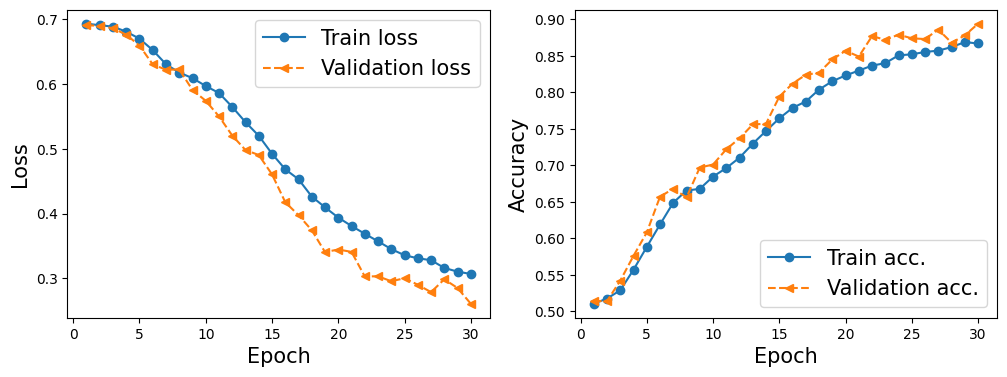

In [26]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

- Once we are happy with the learning curves, we can evaluate the model on the hold-out test dataset:

In [27]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.8993


- Finally, we already know how to get the prediction results on some test examples. In the following code, we will take a small subset of `10 examples` from the last batch of our pre-processed test dataset (test_dl). Then, we will compute the probabilities of each example being from class 1 (which corresponds to smile based on the labels provided in CelebA) and visualize the examples along with their ground truth label and the predicted probabilities:

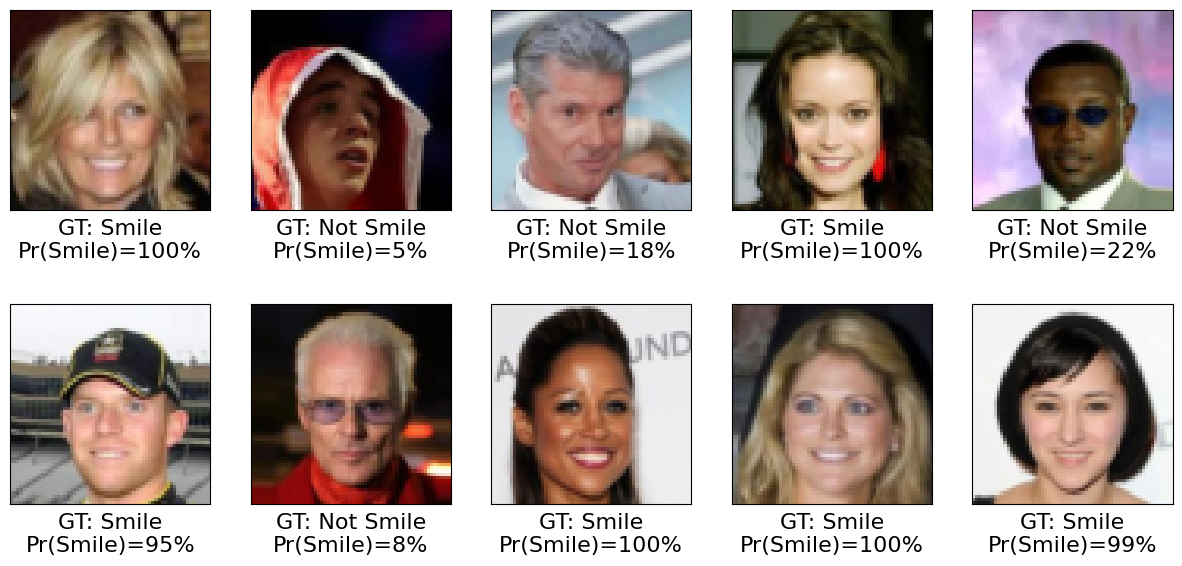

In [28]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15, 
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

- The probabilities of class 1 (that is, smile according to CelebA) are provided below each image. As you can see, our trained model is completely accurate on this set of 10 test examples.

In [29]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'
torch.save(model, path)